<a href="https://colab.research.google.com/github/KaziShahHamza/Wildfire_Prediciton_Research/blob/main/Thesis_Codes_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Load Dataset
import pandas as pd

file_path = '/content/drive/MyDrive/datasets/PREPROCESSED_01_CA_Weather_Fire_Dataset_1984-2025.csv'

# Read the CSV file
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler


In [ ]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# View numeric columns
print("Numeric columns:", list(numeric_cols))


Numeric columns: ['PRECIPITATION', 'MAX_TEMP', 'MIN_TEMP', 'AVG_WIND_SPEED', 'FIRE_START_DAY', 'YEAR', 'TEMP_RANGE', 'WIND_TEMP_RATIO', 'MONTH', 'LAGGED_PRECIPITATION', 'LAGGED_AVG_WIND_SPEED', 'DAY_OF_YEAR', 'DAY', 'WEEK', 'QUARTER', 'SEASON_Fall', 'SEASON_Spring', 'SEASON_Summer', 'SEASON_Winter', 'TEMP_MEAN', 'IS_RAINY', 'WIND_CATEGORY_Extreme', 'WIND_CATEGORY_High', 'WIND_CATEGORY_Low', 'WIND_CATEGORY_Moderate']


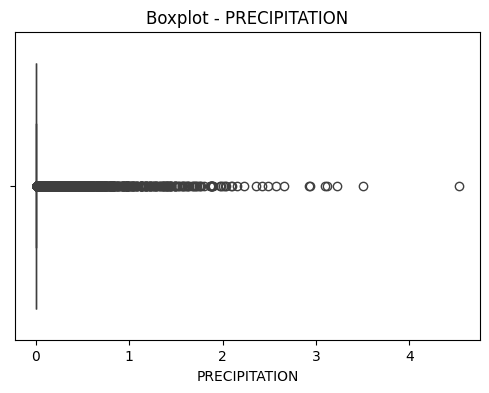

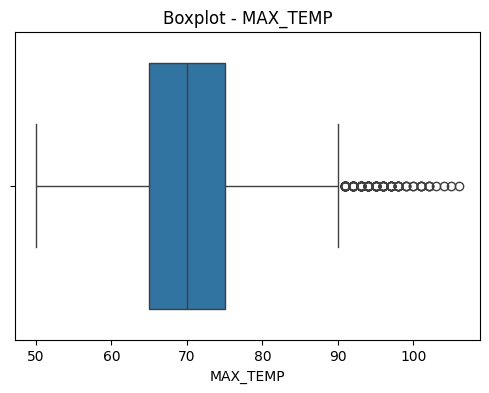

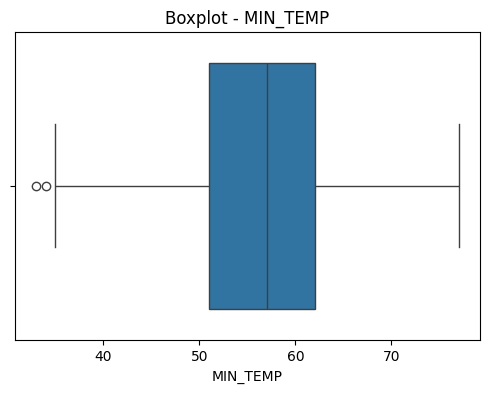

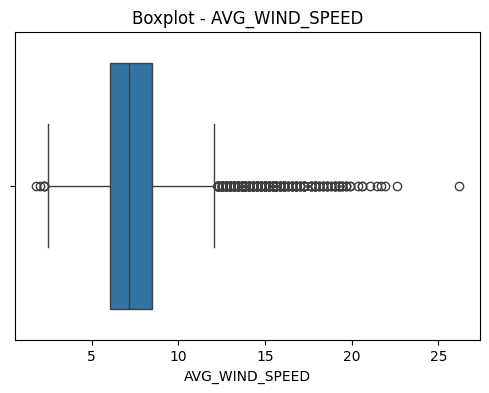

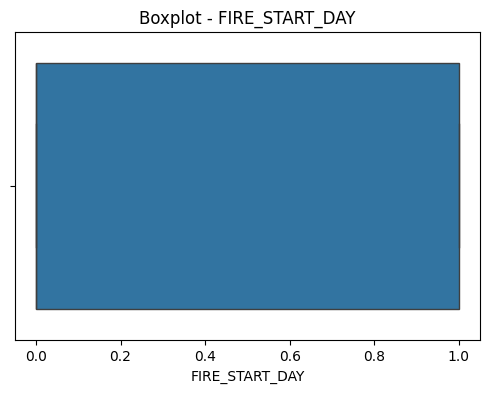

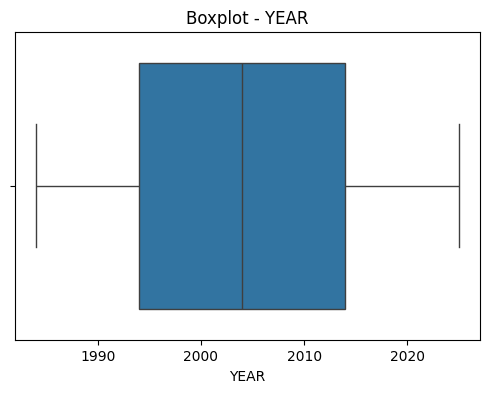

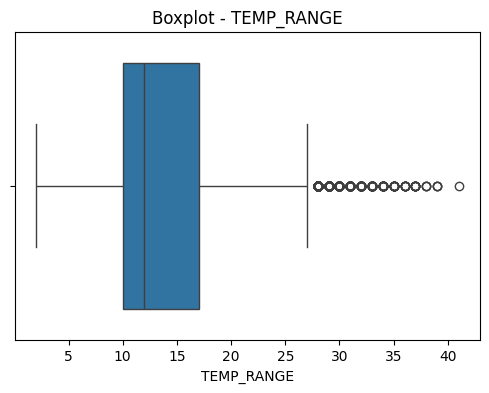

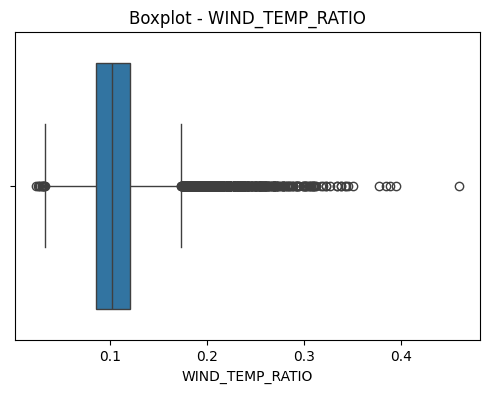

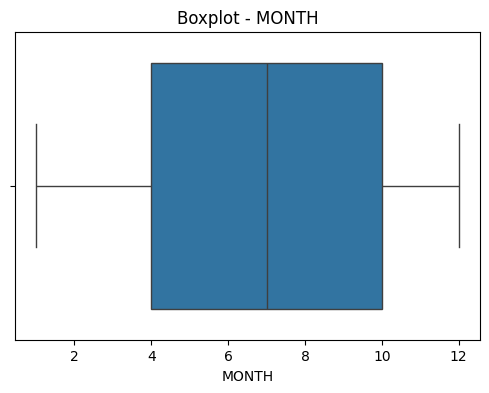

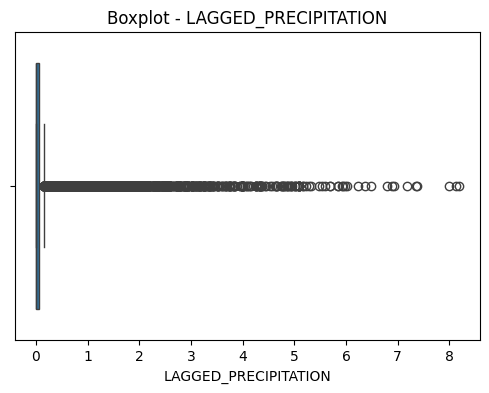

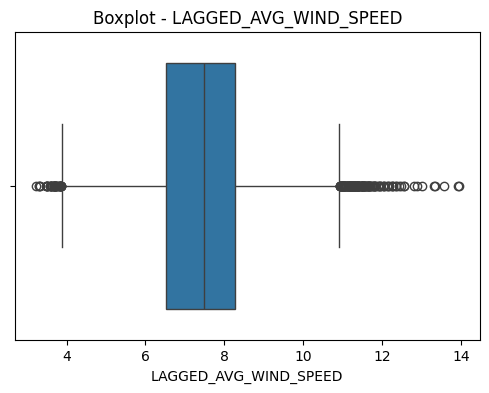

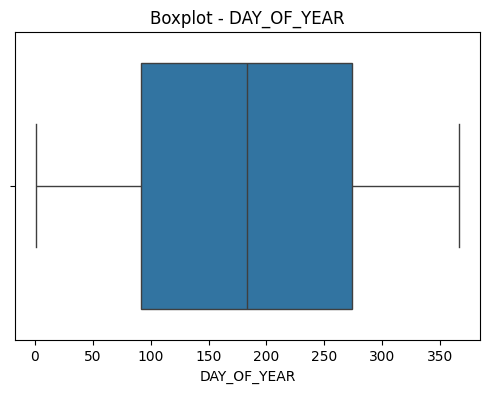

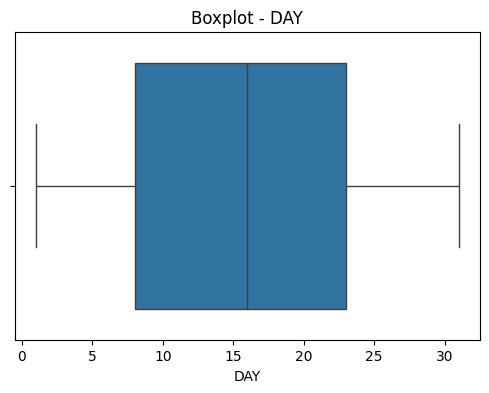

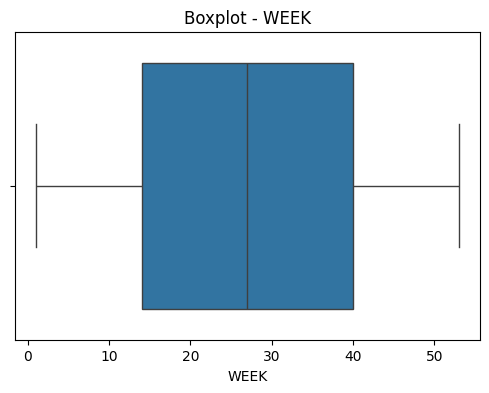

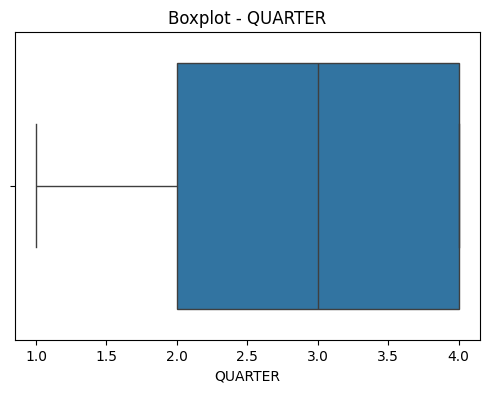

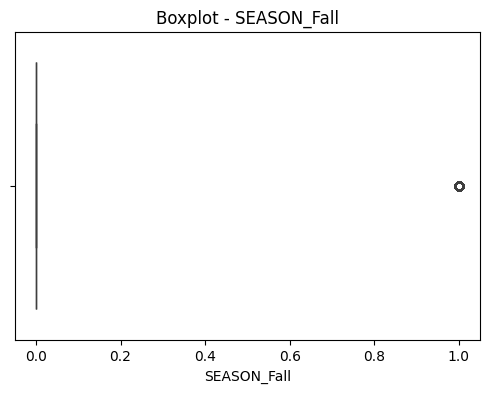

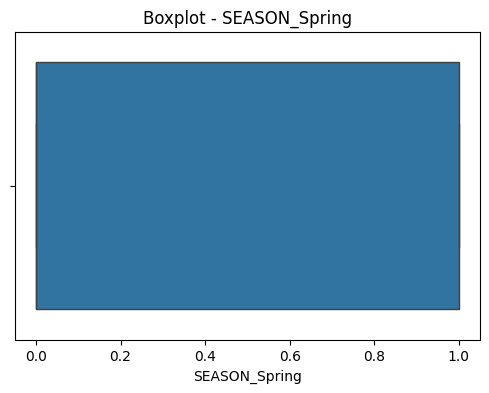

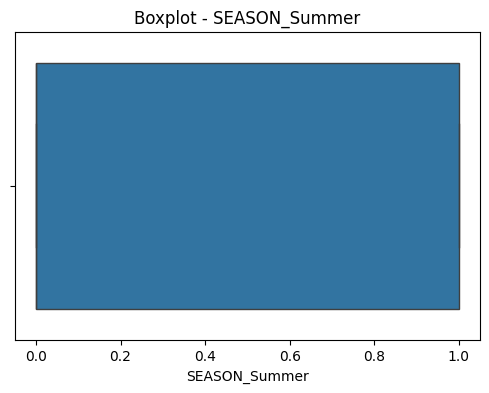

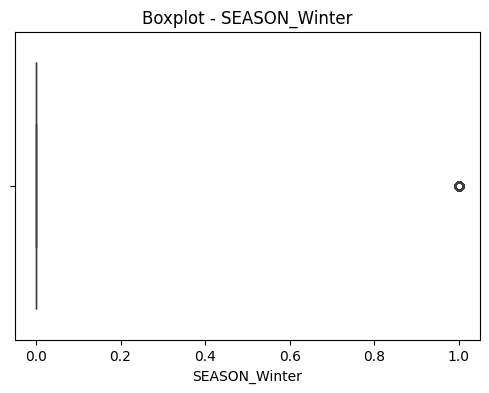

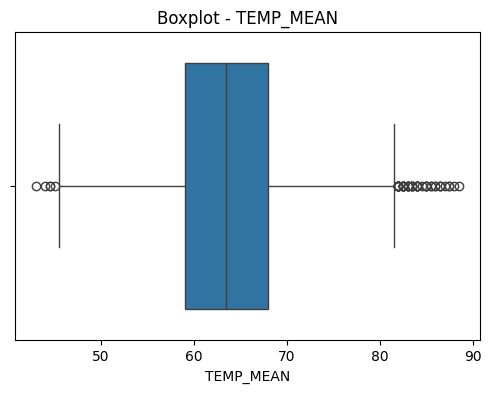

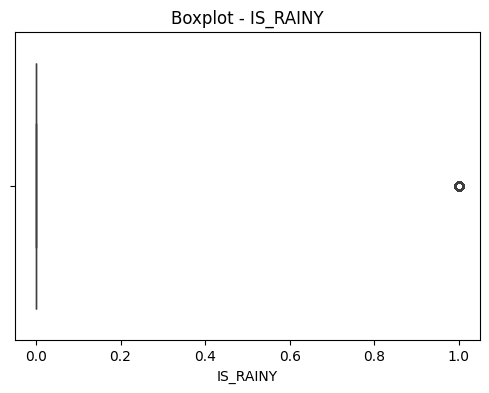

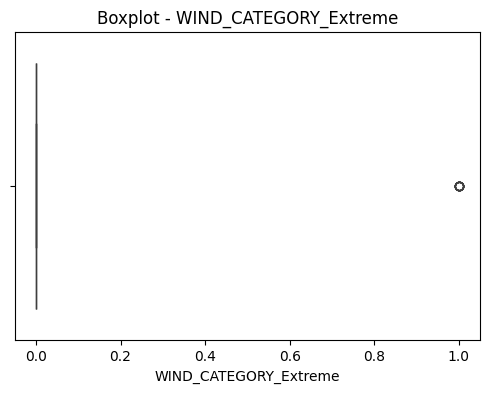

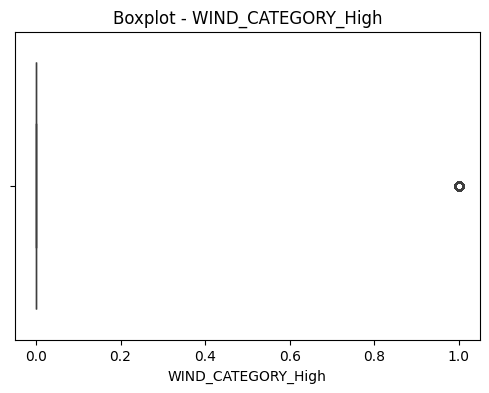

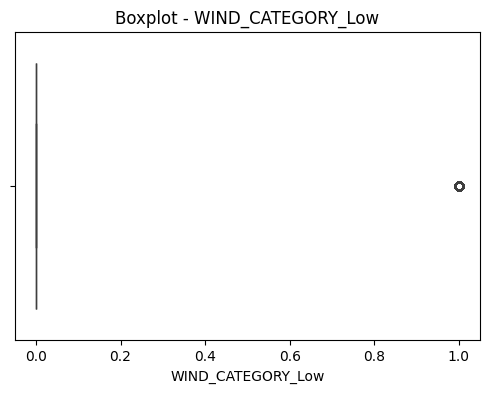

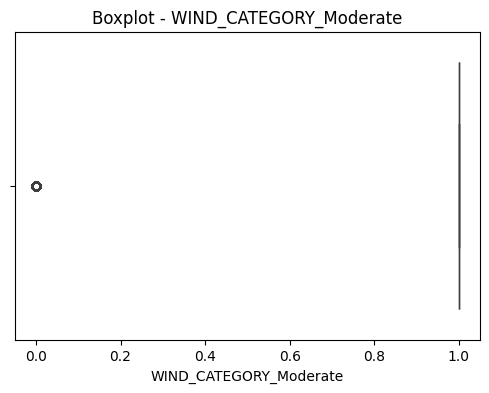

In [ ]:
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot - {col}')
    plt.show()


In [ ]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers

# Example for one column:
outliers_temp = detect_outliers_iqr(df, 'MAX_TEMP')
print(f"Outliers in MAX_TEMP: {len(outliers_temp)}")

# Apply for all numeric columns
outlier_counts = {col: len(detect_outliers_iqr(df, col)) for col in numeric_cols}
print("Outlier counts per column:\n", outlier_counts)


Outliers in MAX_TEMP: 161
Outlier counts per column:
 {'PRECIPITATION': 1381, 'MAX_TEMP': 161, 'MIN_TEMP': 2, 'AVG_WIND_SPEED': 479, 'FIRE_START_DAY': 0, 'YEAR': 0, 'TEMP_RANGE': 573, 'WIND_TEMP_RATIO': 736, 'MONTH': 0, 'LAGGED_PRECIPITATION': 3065, 'LAGGED_AVG_WIND_SPEED': 187, 'DAY_OF_YEAR': 0, 'DAY': 0, 'WEEK': 0, 'QUARTER': 0, 'SEASON_Fall': 3731, 'SEASON_Spring': 0, 'SEASON_Summer': 0, 'SEASON_Winter': 3713, 'TEMP_MEAN': 57, 'IS_RAINY': 1381, 'WIND_CATEGORY_Extreme': 9, 'WIND_CATEGORY_High': 1351, 'WIND_CATEGORY_Low': 1451, 'WIND_CATEGORY_Moderate': 2811}


In [ ]:
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

print("Data scaled using RobustScaler (less sensitive to outliers).")


Data scaled using RobustScaler (less sensitive to outliers).


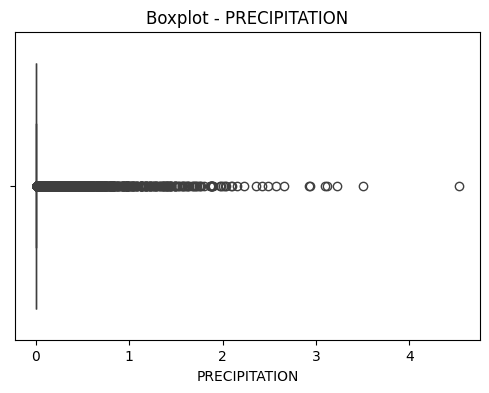

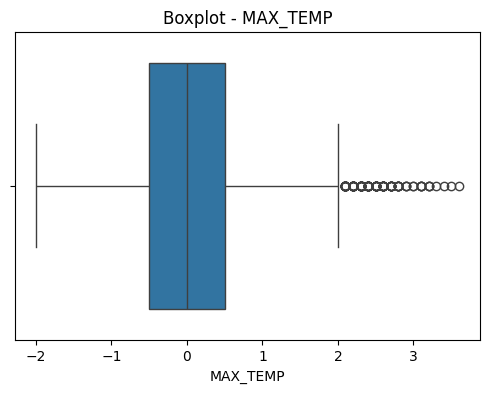

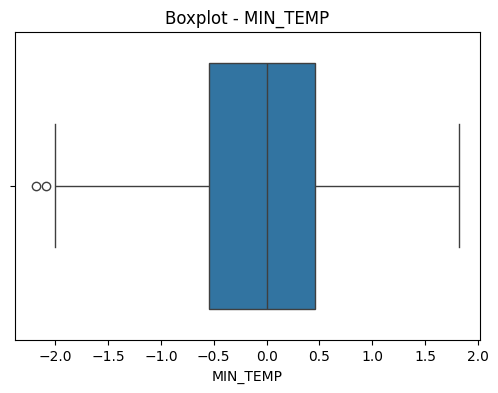

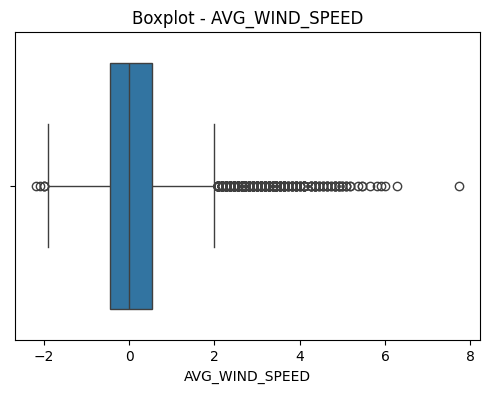

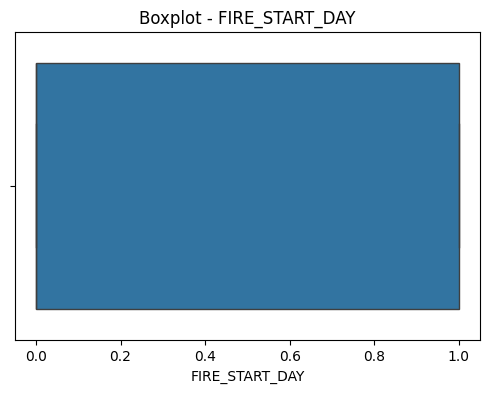

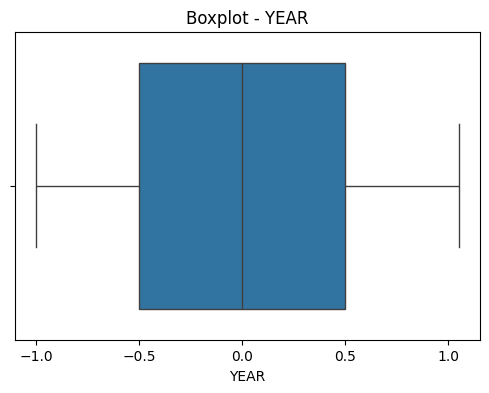

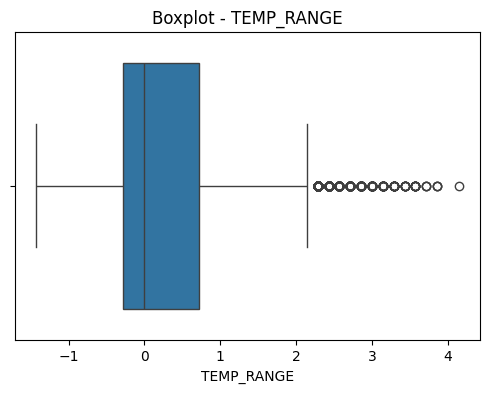

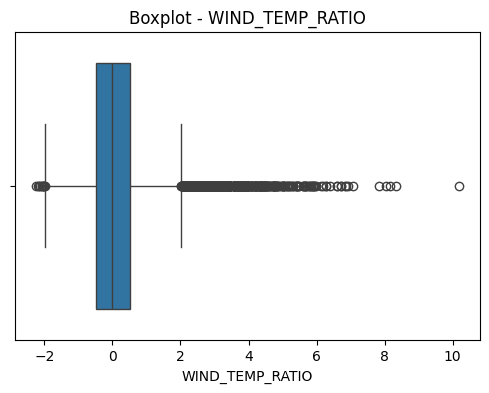

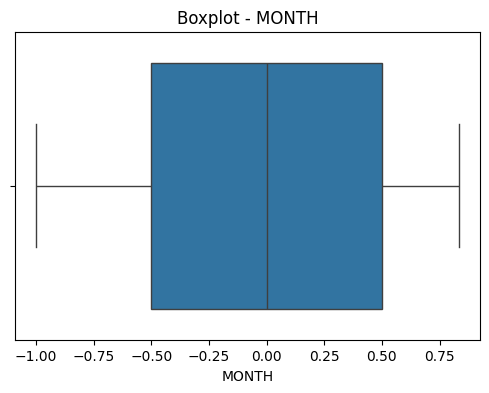

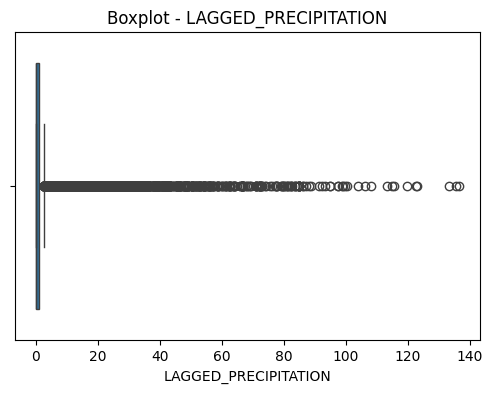

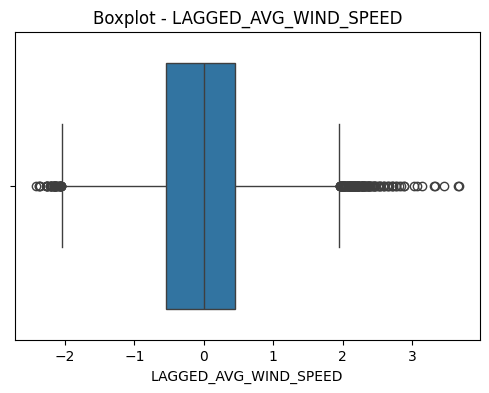

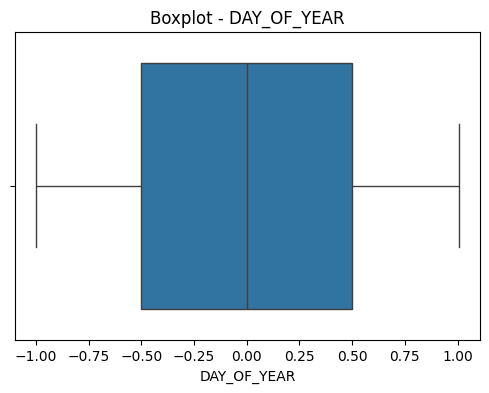

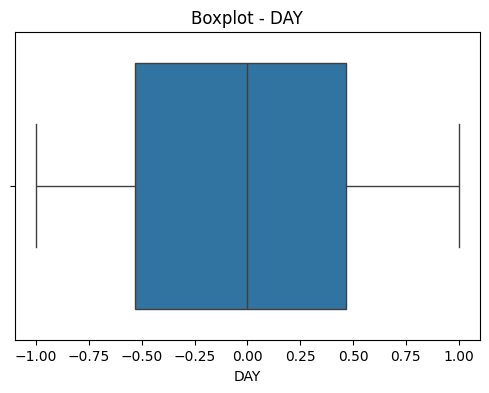

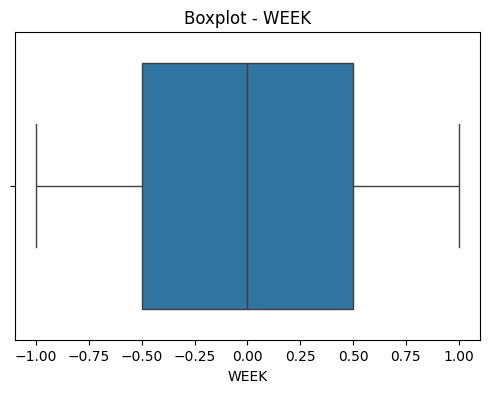

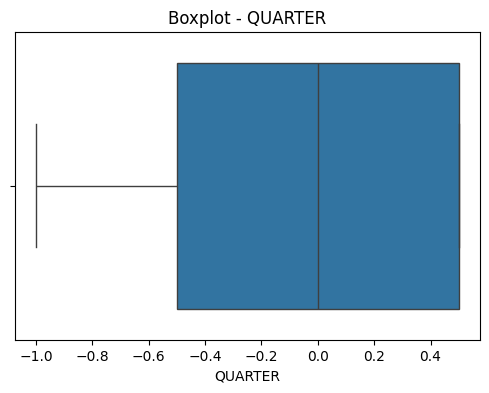

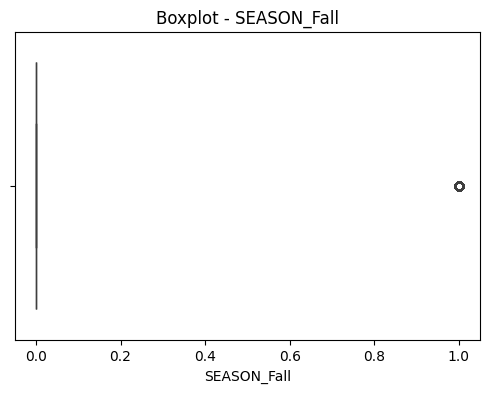

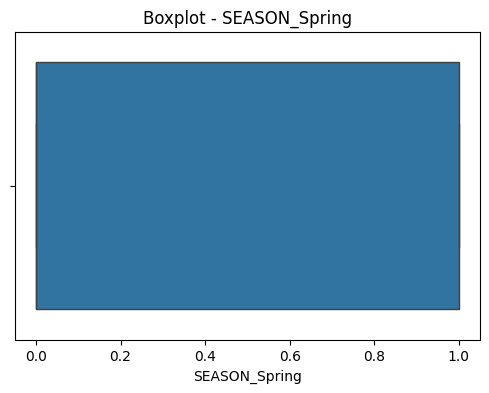

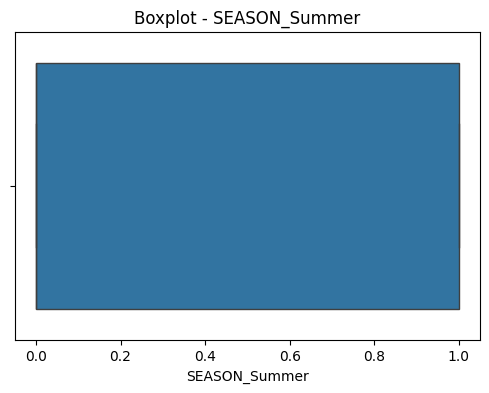

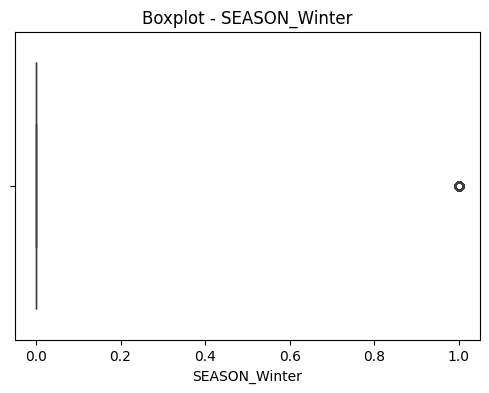

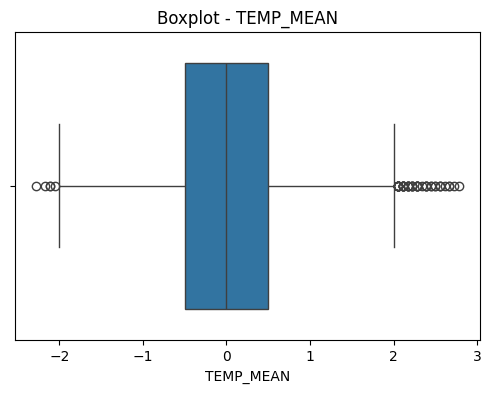

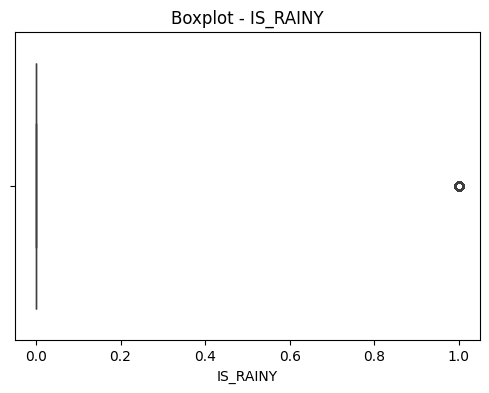

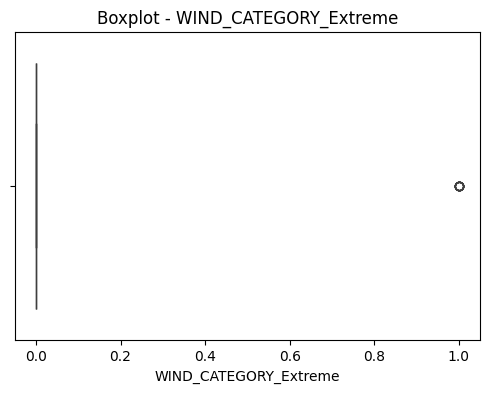

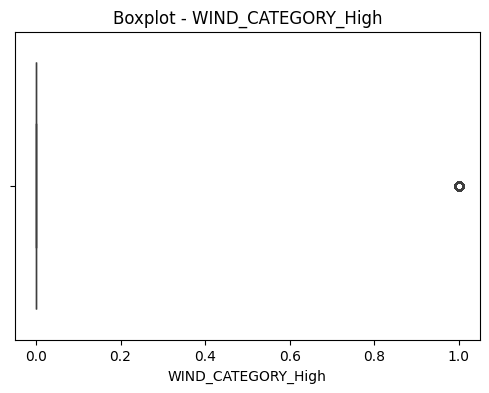

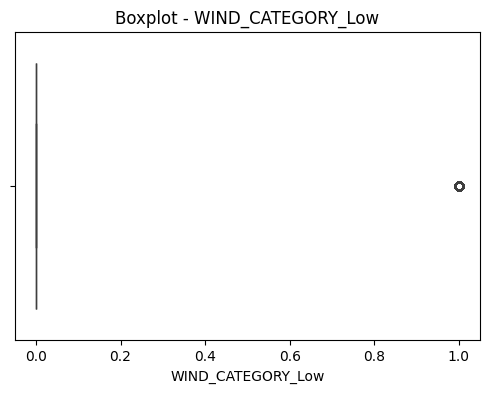

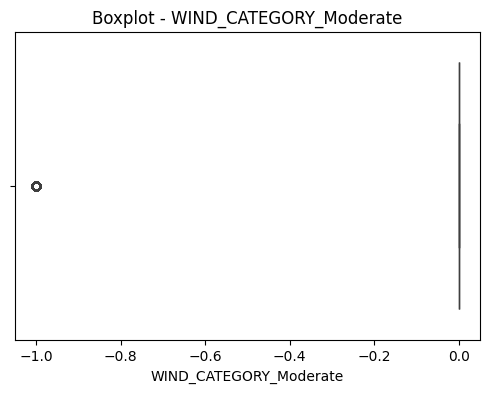

In [ ]:
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_scaled[col])
    plt.title(f'Boxplot - {col}')
    plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features (X) and target (y)
X = df_scaled.drop(columns=['FIRE_START_DAY', 'DATE'])  # example target
y = df_scaled['FIRE_START_DAY']

# Split first (to prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data scaled and split into train/test sets.")

✅ Data scaled and split into train/test sets.


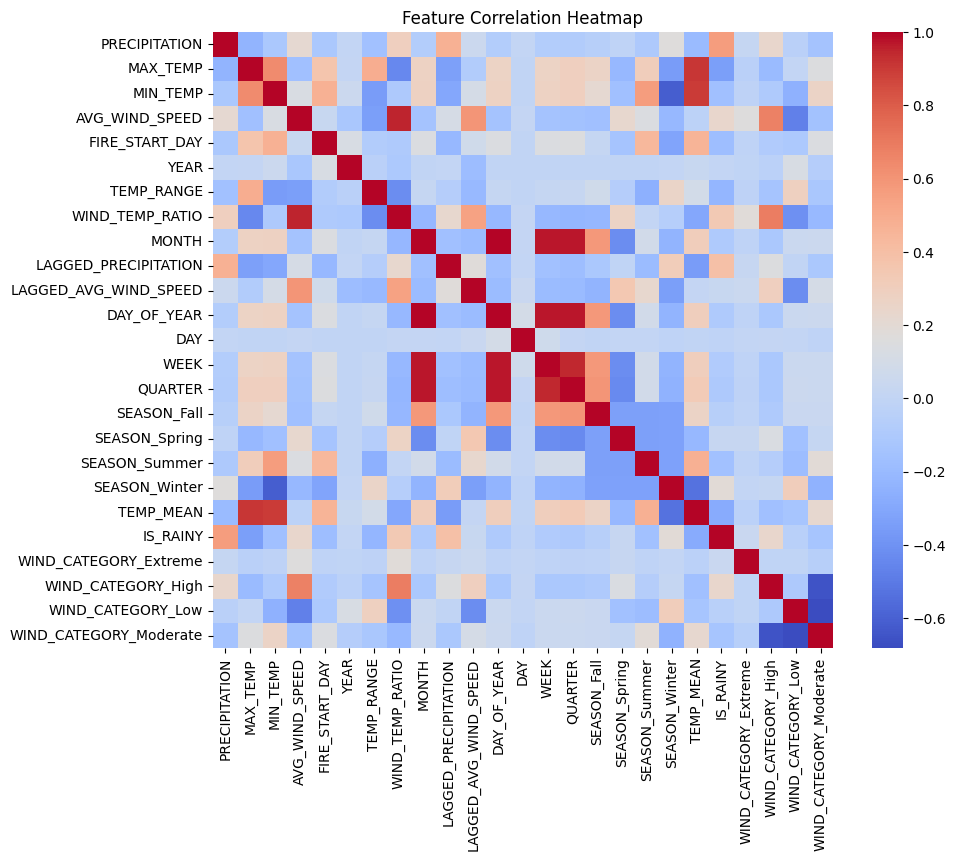

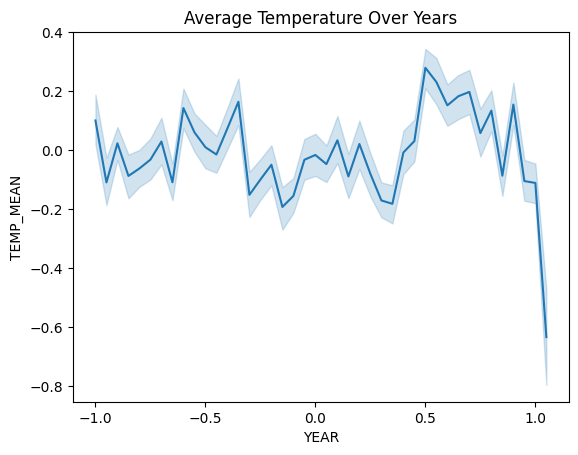

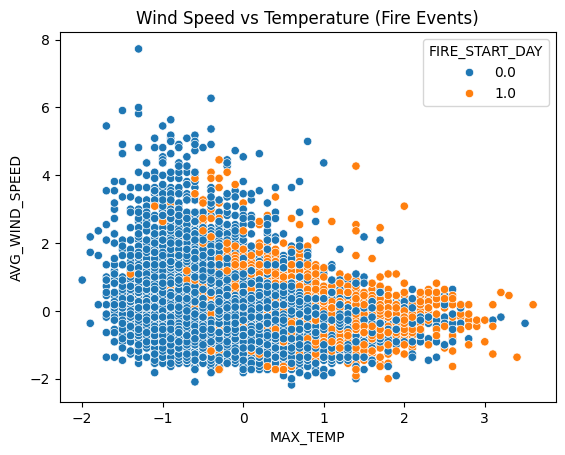

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_scaled.drop(columns=['DATE']).corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Trend over years
sns.lineplot(data=df_scaled, x='YEAR', y='TEMP_MEAN')
plt.title('Average Temperature Over Years')
plt.show()

# Scatter between temperature and fire occurrences
sns.scatterplot(data=df_scaled, x='MAX_TEMP', y='AVG_WIND_SPEED', hue='FIRE_START_DAY')
plt.title('Wind Speed vs Temperature (Fire Events)')
plt.show()

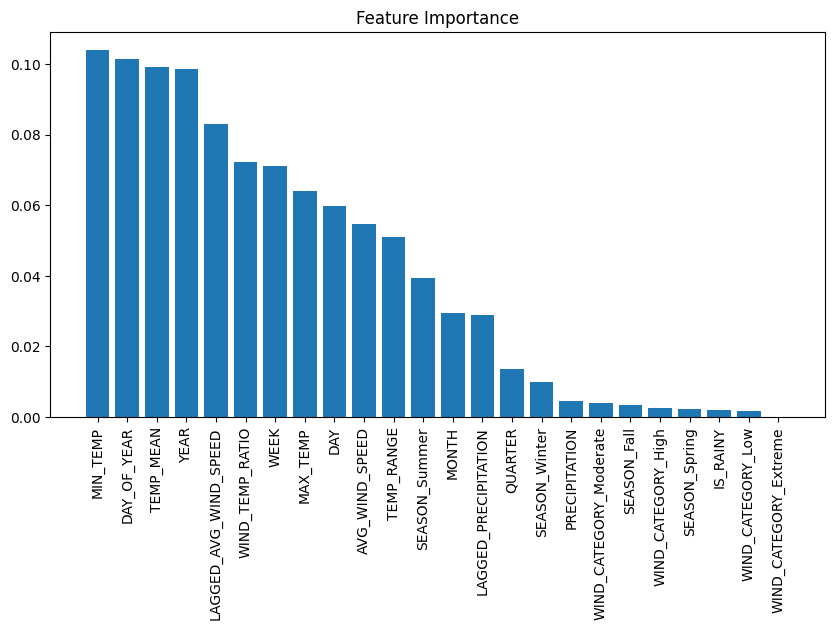

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,5))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))

# Get classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

print("Precision:", report['1.0']['precision'])
print("Recall:", report['1.0']['recall'])
print("F1-score:", report['1.0']['f1-score'])

print(classification_report(y_test, y_pred))


Accuracy: 0.7791861240827218
Precision: 0.6880189798339265
Recall: 0.59244126659857
F1-score: 0.6366630076838639
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84      2019
         1.0       0.69      0.59      0.64       979

    accuracy                           0.78      2998
   macro avg       0.75      0.73      0.74      2998
weighted avg       0.77      0.78      0.77      2998




Logistic Regression
Accuracy: 0.7658
Precision: 0.6691
Recall: 0.5598
F1 Score: 0.6096
              precision    recall  f1-score   support

         0.0       0.80      0.87      0.83      2019
         1.0       0.67      0.56      0.61       979

    accuracy                           0.77      2998
   macro avg       0.74      0.71      0.72      2998
weighted avg       0.76      0.77      0.76      2998



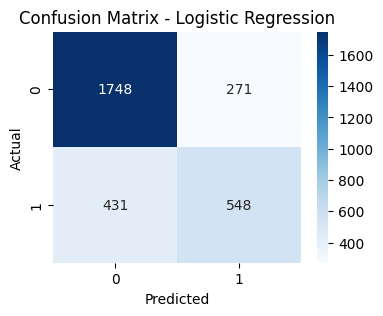


Random Forest
Accuracy: 0.7772
Precision: 0.6827
Recall: 0.5935
F1 Score: 0.6350
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84      2019
         1.0       0.68      0.59      0.63       979

    accuracy                           0.78      2998
   macro avg       0.75      0.73      0.74      2998
weighted avg       0.77      0.78      0.77      2998



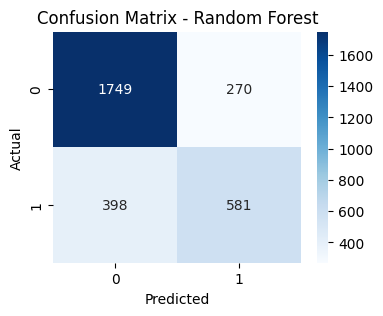


Gradient Boosting
Accuracy: 0.7805
Precision: 0.6873
Recall: 0.6016
F1 Score: 0.6416
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84      2019
         1.0       0.69      0.60      0.64       979

    accuracy                           0.78      2998
   macro avg       0.75      0.73      0.74      2998
weighted avg       0.78      0.78      0.78      2998



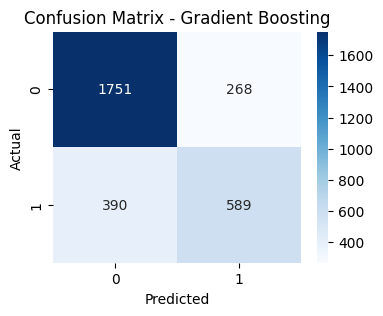


SVM
Accuracy: 0.7708
Precision: 0.6751
Recall: 0.5751
F1 Score: 0.6211
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84      2019
         1.0       0.68      0.58      0.62       979

    accuracy                           0.77      2998
   macro avg       0.74      0.72      0.73      2998
weighted avg       0.76      0.77      0.77      2998



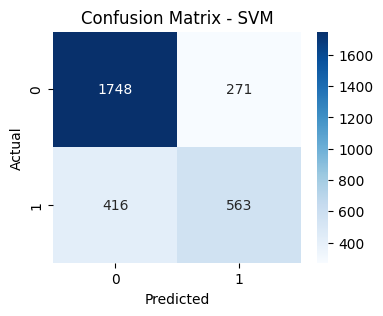


KNN
Accuracy: 0.7582
Precision: 0.6473
Recall: 0.5700
F1 Score: 0.6062
              precision    recall  f1-score   support

         0.0       0.80      0.85      0.83      2019
         1.0       0.65      0.57      0.61       979

    accuracy                           0.76      2998
   macro avg       0.73      0.71      0.72      2998
weighted avg       0.75      0.76      0.75      2998



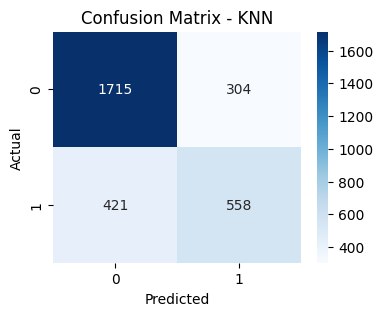


✅ Model Comparison Table:


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.765844,0.669109,0.559755,0.609566
1,Random Forest,0.777185,0.682726,0.593463,0.634973
2,Gradient Boosting,0.780520,0.687281,0.601634,0.641612
3,SVM,0.770847,0.675060,0.575077,0.621070
4,KNN,0.758172,0.647332,0.569969,0.606192


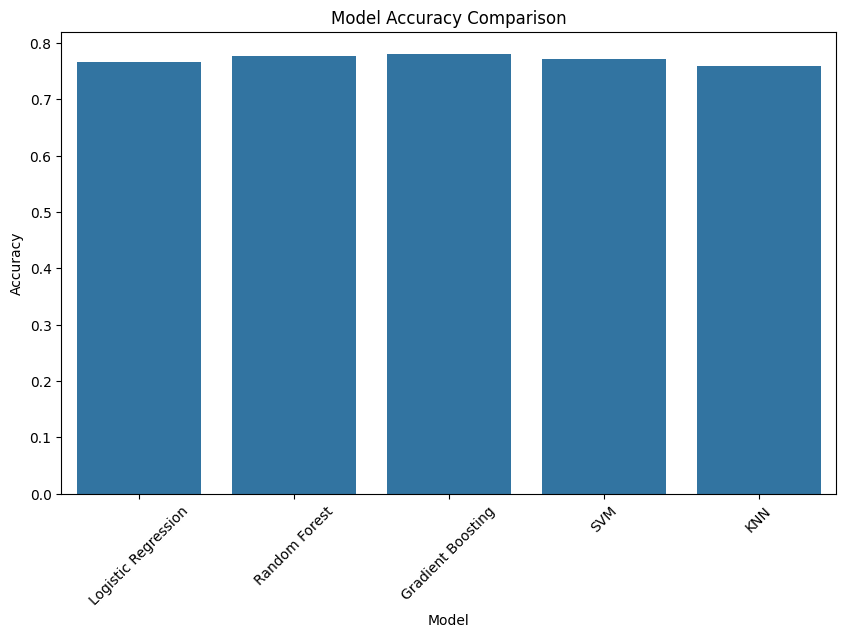

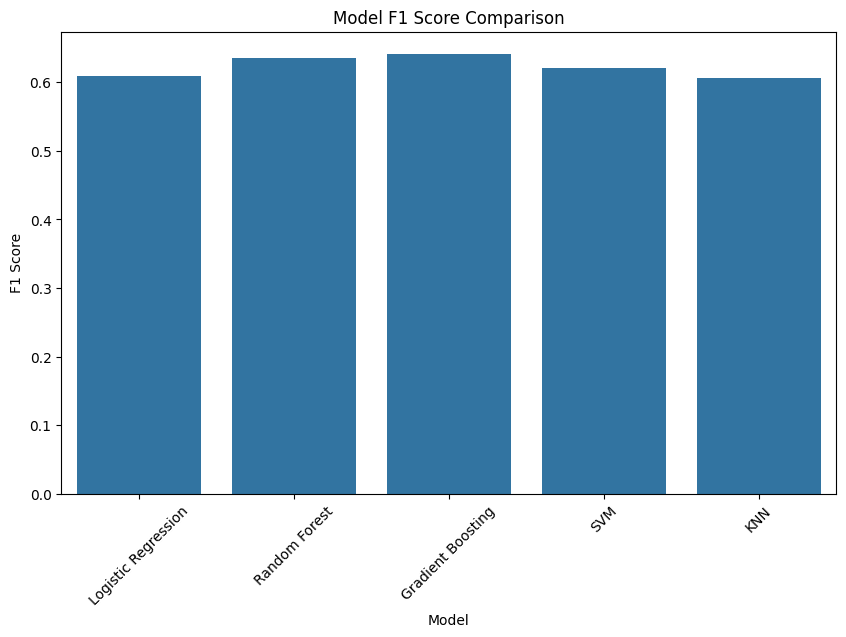

In [ ]:
# --- Import dependencies ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Initialize models ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7)
}

# --- Train, Predict, and Evaluate ---
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary', zero_division=0)
    rec = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print(classification_report(y_test, y_pred))


    # Confusion Matrix visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results)
print("\n✅ Model Comparison Table:")
display(results_df)

# --- Visualize performance comparison ---
plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x="Model", y="F1 Score", data=results_df)
plt.title("Model F1 Score Comparison")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Check target balance
y_train.value_counts(normalize=True)

# If imbalance exists, apply SMOTE to balance classes
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_scaled, y_train)

print("Before:", y_train.value_counts())
print("After SMOTE:", y_train_bal.value_counts())


Before: FIRE_START_DAY
0.0    7998
1.0    3992
Name: count, dtype: int64
After SMOTE: FIRE_START_DAY
1.0    7998
0.0    7998
Name: count, dtype: int64
